# Model comparison pipeline

- Pipeline components:
    - normalisation + scaling
    - imputation
    - ML model

- Took care that `random seeds` are fixed, so models get compared with the same split!

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import seaborn as sns

from modelsClassifier import fit_modelComparison

sns.set_theme(style="whitegrid", palette=None, font_scale=1.2)

# Classification pipeline

In [2]:
datasetTimepoint = "12_uponAdmission"
target = "disease_severity"
#### Feature selection:
vars = "borutaManual"    # boruta+bestSterols
varPath = f"../../results/featureSelection/{datasetTimepoint}/{vars}.txt"

''' 
Define paths
'''
resultsPath = f"../../results/prediction/featureSelection/{datasetTimepoint}/{vars}/modelComparison"
os.makedirs(resultsPath, exist_ok=True)
dataPath = "../../results/preprocessing/cleaned"
dataset = f"{datasetTimepoint}_{target}_cleaned.csv"

In [3]:
''' 
Read data
'''
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0)
X = data.drop(target, axis=1)
y = data[target]

''' 
Read in variables
'''
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Run pipeline

--model: RandomForest, LogReg, KNN, GBoost, MLP

'''
for model in ["RandomForest"]:#, "LogReg", "KNN", "GBoost", "MLP"]:
    estimators, score = fit_modelComparison(X, y, target, sel_variables, model=model, randomState=11)

    ### Save
    score["model"] = np.repeat(model, len(score["fit_time"]))
    pd.DataFrame.from_dict(score).to_csv(f"{resultsPath}/{model}_score.csv", index=None) 

    ### Save feature importances if possible
    if model == "RandomForest":
        columnOrderAfterPreprocessing = estimators[0].best_estimator_["selector"].get_feature_names()
        fi_rf = list(zip(estimators[0].best_estimator_[model].feature_importances_, columnOrderAfterPreprocessing))
        df_fi_rf = pd.DataFrame(fi_rf, columns=["fi", "var"]).sort_values("fi", ascending=False)    
        df_fi_rf.to_csv(f"{resultsPath}/{model}_featureImportance.csv", index=None)


Fitting estimator...



# Comparison of all models

In [17]:
df_scores = pd.DataFrame()

for model in ["RandomForest", "LogReg", "KNN", "GBoost", "MLP"]:
    df = pd.read_csv(f"{resultsPath}/{model}_score.csv")
    df_scores = pd.concat([df_scores, df], axis=0, ignore_index=True)

df_scores

,fit_time,score_time,test_acc,test_b_acc,test_recall,test_precision,test_roc_auc_micro,test_roc_auc_macro,test_f1,test_f1_micro,test_f1_macro,test_f1_weighted,test_fbeta,model
0,13.520286,0.672601,0.927273,0.916667,0.933333,0.976744,0.971111,0.971111,0.954545,0.927273,0.886364,0.929752,0.941704,RandomForest
1,12.020909,0.669492,0.981818,0.950000,1.000000,0.978261,0.993333,0.993333,0.989011,0.981818,0.968190,0.981440,0.995575,RandomForest
2,11.261563,0.947018,0.944444,0.888636,0.977273,0.955556,0.986364,0.986364,0.966292,0.944444,0.904199,0.943295,0.972851,RandomForest
3,16.314379,0.656395,0.909091,0.866667,0.933333,0.954545,0.955556,0.955556,0.943820,0.909091,0.852862,0.910745,0.937500,LogReg
4,16.000044,0.642167,0.945455,0.850000,1.000000,0.937500,0.997778,0.997778,0.967742,0.945455,0.895636,0.941521,0.986842,LogReg
5,15.758799,0.915256,0.907407,0.904545,0.909091,0.975610,0.972727,0.972727,0.941176,0.907407,0.861893,0.911812,0.921659,LogReg
6,11.514054,0.734701,0.927273,0.916667,0.933333,0.976744,0.955556,0.955556,0.954545,0.927273,0.886364,0.929752,0.941704,KNN
7,12.140644,0.689789,0.945455,0.888889,0.977778,0.956522,0.993333,0.993333,0.967033,0.945455,0.904569,0.944319,0.973451,KNN
8,11.364459,0.953635,0.925926,0.915909,0.931818,0.976190,0.927273,0.927273,0.953488,0.925926,0.885835,0.928432,0.940367,KNN
9,66.505767,0.659035,0.945455,0.966667,0.933333,1.000000,0.983333,0.983333,0.965517,0.945455,0.917541,0.948071,0.945946,GBoost


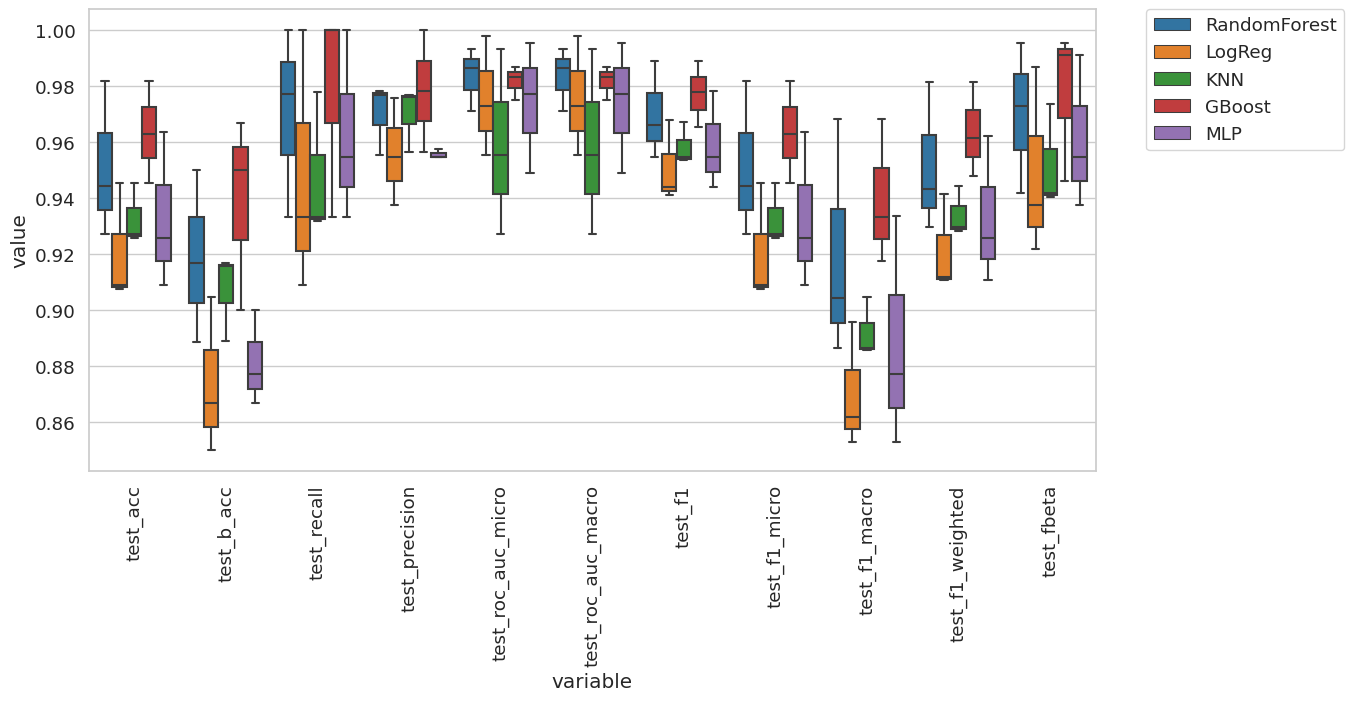

In [18]:
df_plot = df_scores.drop(["fit_time", "score_time"], axis=1)
df_plot = df_plot.melt("model")

fig, ax = plt.subplots(figsize=(13,6))
sns.boxplot(data=df_plot, x="variable", y="value", hue="model")
ax.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Inspect feature importances

## Random Forest

Text(0.5, 1.0, 'RandomForest')

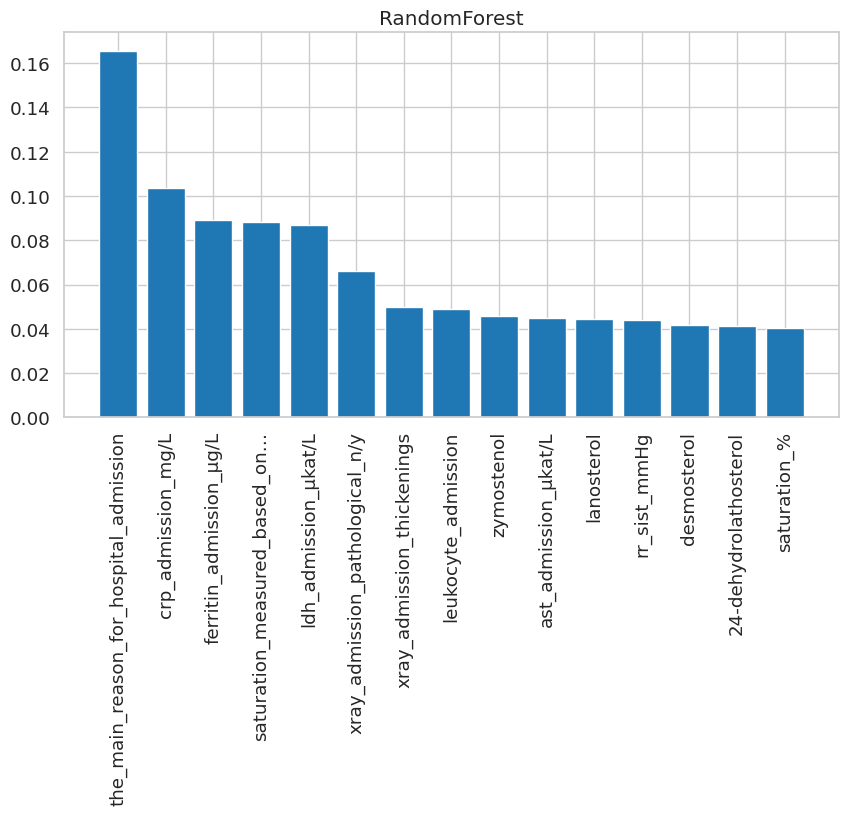

In [14]:
df = pd.read_csv(f"{resultsPath}/RandomForest_featureImportance.csv")

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(df_fi_rf["var"], df_fi_rf["fi"])
ax.tick_params(axis='x', rotation=90)
plt.title(f"RandomForest")

## Gradient Boosting

In [ ]:
model = "GBoost"
estimators, score = fit_modelComparison(X, y, target, model=model, randomState=11)

fi_gboost = list(zip(estimators[0].best_estimator_[model].feature_importances_, columnOrderAfterPreprocessing))
df_fi_gboost = pd.DataFrame(fi_gboost, columns=["fi", "var"]).sort_values("fi", ascending=False)
df_fi_gboost

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(df_fi_gboost.iloc[:10,]["var"], df_fi_gboost.iloc[:10,]["fi"], color="darkred")
ax.tick_params(axis='x', rotation=90)
plt.title(f"{model}: top 10")

## Logistic Regression

In [ ]:
model = "LogReg"
estimators, score = fit_modelComparison(X, y, target, model=model, randomState=11)

fi_logreg = list(zip(estimators[0].best_estimator_[model].coef_[0], columnOrderAfterPreprocessing))
df_fi_logreg = pd.DataFrame(fi_logreg, columns=["fi", "var"]).sort_values("fi", ascending=False)
df_fi_logreg

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(df_fi_logreg.iloc[:10]["var"], df_fi_logreg.iloc[:10]["fi"], color="orange")
ax.tick_params(axis='x', rotation=90)
plt.title(f"{model}: top 10")